In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib
from os import getcwd, path
from datetime import datetime
import matplotlib.pyplot as plt

In [24]:
cwd = os.getcwd()
data_dir = path.join(cwd, "data")
daily_path = path.join(data_dir,"daily_user.csv")
heavy_path = path.join(data_dir,"heavy_user.csv")
moderate_path =path.join(data_dir,"moderate_user.csv")
rare_path = path.join(data_dir,"rare_user.csv")


In [40]:
def make_df(user_type: str, data_dir: str):
    file_path = path.join(data_dir, f"{user_type}_user.csv")
    df = pd.read_csv(file_path)

    s = df.iloc[:, 0].astype(str).str.strip()
    ts = pd.to_datetime(s, format="%d-%m-%y %H:%M", errors="coerce")

    df["date"] = ts.dt.date
    df["time"] = ts.dt.time

    df.drop(df.columns[0], axis=1, inplace=True)

    return df

In [32]:
daily_df = make_df("daily", data_dir)
heavy_df = make_df("heavy", data_dir)
moderate_df = make_df("moderate", data_dir)
rare_df = make_df("rare", data_dir)

In [38]:
print(daily_df.columns)

Index(['SOC', 'SOH', 'Charging_Cycles', 'Battery_Temp', 'Motor_RPM',
       'Motor_Torque', 'Motor_Temp', 'Brake_Pad_Wear', 'Charging_Voltage',
       'Tire_Pressure', 'DTC', 'date', 'time'],
      dtype='object')


In [44]:
print(daily_df['DTC'].unique())
print(heavy_df['DTC'].unique())
print(moderate_df['DTC'].unique())
print(rare_df['DTC'].unique())

['0' 'P0MR' 'P0MT' 'P0T' 'P0S' 'P0P']
['0' 'P0MR' 'P0MT' 'P0T' 'P0MR,P0MT' 'P0T,P0MR' 'P0P' 'P0B' 'P0S']
['0' 'P0MR' 'P0MT' 'P0T' 'P0P' 'P0S']
['0' 'P0MT' 'P0MR' 'P0T' 'P0P' 'P0S' 'P0B']


In [54]:
def DTC_distribution(df):
    codes = df["DTC"]
    
    # --- Pie 1: zero vs non-zero ---
    zero_count = (codes == '0').sum()
    non_zero_count = (codes != '0').sum()
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.pie(
        [zero_count, non_zero_count],
        labels=["0", "Non-0"],
        autopct="%1.1f%%",
        colors=["#66c2a5", "#fc8d62"]
    )
    plt.title("Zero vs Non-Zero DTC")
    
    # --- Pie 2: individual non-zero codes ---
    non_zero_counts = codes[codes != '0'].value_counts()
    
    plt.subplot(1,2,2)
    plt.pie(
        non_zero_counts,
        labels=[f"{c}" for c in non_zero_counts.index],
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title("Distribution of Non-Zero Codes")
    
    plt.tight_layout()
    plt.show()

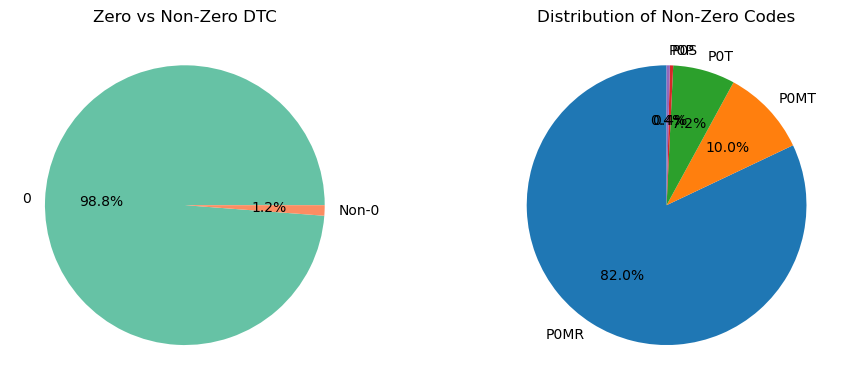

In [56]:
DTC_distribution(daily_df)

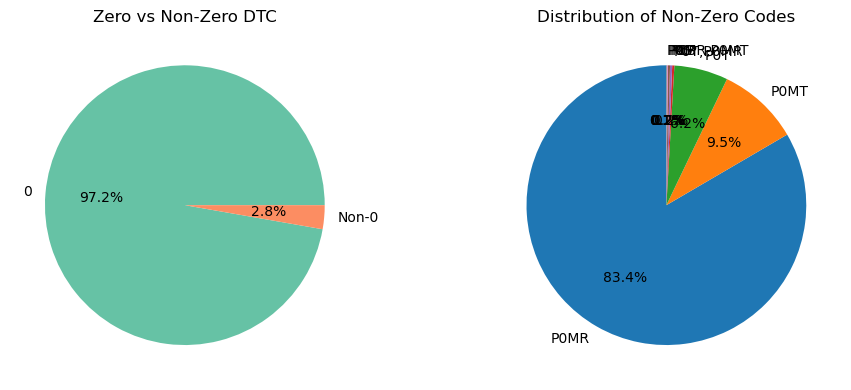

In [60]:
DTC_distribution(heavy_df)

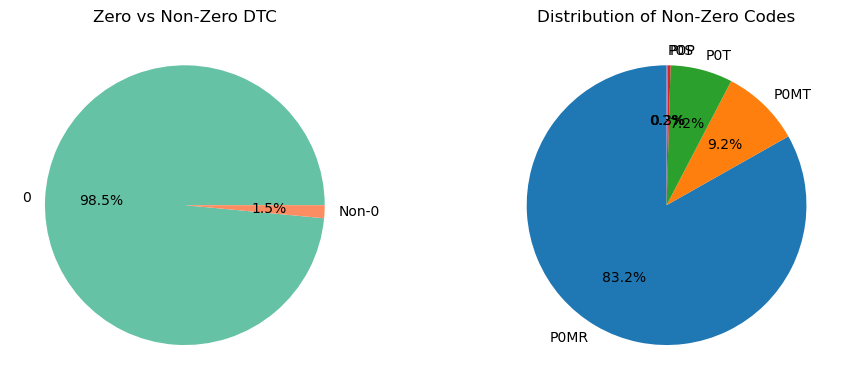

In [62]:
DTC_distribution(moderate_df)

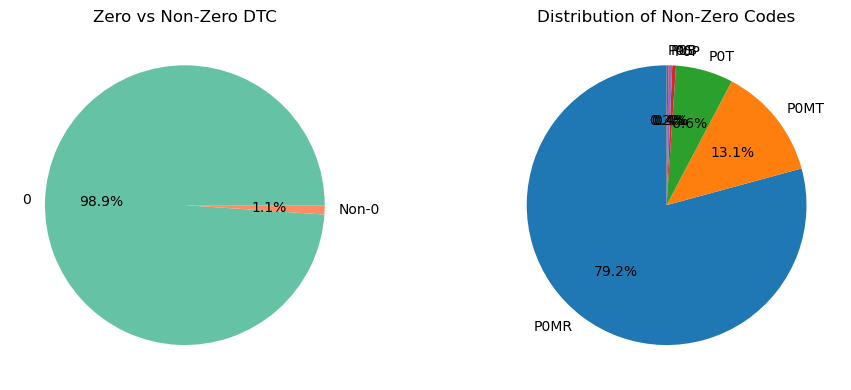

In [64]:
DTC_distribution(rare_df)